In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
%matplotlib inline

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [49]:
def normalize_angle(angle):
    while (angle > math.pi):
        angle = angle - 2*math.pi
    while (angle < -math.pi):
        angle = angle + 2*math.pi
    return angle


class MotionModel:
    def __init__(self, pose):
        self.pose = np.copy(pose)   
        
    @property
    def pose(self):
        return self.pose
    
    @pose.setter
    def pose(self, new_pose):
        self.pose = np.copy(new_pose)
    
    @pose.deleter
    def pose(self):
        self.pose = None
        del self.pose
        
    def motion_command(self, command):
        rot1 = command[0]
        trans = command[1]
        rot2 = command[2]
        
        theta_old = normalize_angle(self.pose.item(2))
        
        update_vec = np.matrix([
            trans*math.cos(theta_old + rot1),
            trans*math.sin(theta_old + rot1),
            rot1 + rot2
        ]).T
        
        self.pose = self.pose + update_vec
        
        return self.pose

        
class BaseRobot:
    def __init__(self, x, y, theta, motion_model=None):
        self.pose = np.matrix([x, y, theta]).T
        self.motion = motion_model
    
    @property
    def pose(self):
        return self.pose
    
    @pose.setter
    def pose(self, new_pose):
        self.pose = np.copy(new_pose)
    
    @pose.deleter
    def pose(self):
        self.pose = None
        del self.pose
    
    @property
    def motion(self):
        return self.motion
    
    @motion.setter
    def motion(self, motion_model):
        self.motion = motion_model
    
    @motion.deleter
    def motion(self):
        del self.motion
        
    def motion_command(self, command):
        self.pose = self.motion.motion_command(command)

In [62]:
def read_data(filename):
    odometry = []
    sensor = []
    with open(filename, 'r') as f:
        for line in f:
            data = line.strip().split(" ")
            data[1:] = [float(d) for d in data[1:]]
        
            if data[0] == "ODOMETRY":
                odometry.append(tuple(data[1:]))
            elif data[0] == "SENSOR":
                sensor.append(tuple(data[1:]))
    
    return odometry, sensor
        
odometry, sensor = read_data('./data/simple/sensor_data.dat')

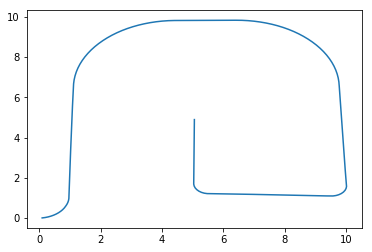

In [66]:
robot = BaseRobot(0, 0, 0)
motion_model = MotionModel(robot.pose)
robot.motion = motion_model

commands = [np.array(odom).T for odom in odometry]

x = []
y = []
for command in commands:
    robot.motion_command(command)
    
    x.append(robot.pose.item(0))
    y.append(robot.pose.item(1))
    
plt.plot(x, y)